<a href="https://colab.research.google.com/github/Yuvaraj0001/EVA7_Assignments/blob/main/Session%206/Normalization/Group_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Specify Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

## Download Dataset & Specify Transformations

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Device & Dataloader Specifications

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model

In [5]:
dropout_value = 0.05


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.GroupNorm(num_groups=2, num_channels=8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.transblock1 = nn.Sequential(
            nn.MaxPool2d(2,2), ## Squeeze
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False), ## Pointwise Convolution
        ) # output_size = 12
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False), ## Expand number of channels
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=24),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8) ## Global Average Pooling
        ) # output_size = 1

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(1, 1), padding=0, bias=False), ## Increase (expand) number of channels
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.Dropout(dropout_value)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), ## Reduce down number of channels
            nn.ReLU(),
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.Dropout(dropout_value)
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False), ## Reduce number of channels to output required
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.transblock1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Summary

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Define Train & Test Functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Train & Test Model

In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
from torch.optim.lr_scheduler import StepLR, ExponentialLR, OneCycleLR, LambdaLR

lambda1 = lambda epoch: 0.65 ** epoch
scheduler = LambdaLR(optimizer, lr_lambda=lambda1)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.3187883198261261 Batch_id=468 Accuracy=68.95: 100%|██████████| 469/469 [00:52<00:00,  8.93it/s]



Test set: Average loss: 0.1649, Accuracy: 9575/10000 (95.75%)

EPOCH: 2


Loss=0.36077842116355896 Batch_id=468 Accuracy=91.89: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]



Test set: Average loss: 0.1036, Accuracy: 9704/10000 (97.04%)

EPOCH: 3


Loss=0.3209344148635864 Batch_id=468 Accuracy=94.34: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]



Test set: Average loss: 0.0949, Accuracy: 9725/10000 (97.25%)

EPOCH: 4


Loss=0.1649327129125595 Batch_id=468 Accuracy=95.25: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]



Test set: Average loss: 0.0597, Accuracy: 9828/10000 (98.28%)

EPOCH: 5


Loss=0.1269867867231369 Batch_id=468 Accuracy=95.89: 100%|██████████| 469/469 [00:53<00:00,  8.73it/s]



Test set: Average loss: 0.0500, Accuracy: 9861/10000 (98.61%)

EPOCH: 6


Loss=0.12667377293109894 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]



Test set: Average loss: 0.0553, Accuracy: 9844/10000 (98.44%)

EPOCH: 7


Loss=0.06614360958337784 Batch_id=468 Accuracy=96.64: 100%|██████████| 469/469 [00:53<00:00,  8.76it/s]



Test set: Average loss: 0.0400, Accuracy: 9890/10000 (98.90%)

EPOCH: 8


Loss=0.07605466991662979 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]



Test set: Average loss: 0.0393, Accuracy: 9890/10000 (98.90%)

EPOCH: 9


Loss=0.03432478383183479 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]



Test set: Average loss: 0.0361, Accuracy: 9899/10000 (98.99%)

EPOCH: 10


Loss=0.05830519273877144 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:52<00:00,  8.91it/s]



Test set: Average loss: 0.0341, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.2622290551662445 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:52<00:00,  8.85it/s]



Test set: Average loss: 0.0361, Accuracy: 9895/10000 (98.95%)

EPOCH: 12


Loss=0.11016255617141724 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:53<00:00,  8.81it/s]



Test set: Average loss: 0.0374, Accuracy: 9895/10000 (98.95%)

EPOCH: 13


Loss=0.1377233862876892 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]



Test set: Average loss: 0.0313, Accuracy: 9912/10000 (99.12%)

EPOCH: 14


Loss=0.037618622183799744 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:53<00:00,  8.72it/s]



Test set: Average loss: 0.0321, Accuracy: 9911/10000 (99.11%)

EPOCH: 15


Loss=0.08990459889173508 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:53<00:00,  8.77it/s]



Test set: Average loss: 0.0259, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.07104369252920151 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:53<00:00,  8.70it/s]



Test set: Average loss: 0.0317, Accuracy: 9910/10000 (99.10%)

EPOCH: 17


Loss=0.12082871049642563 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:54<00:00,  8.68it/s]



Test set: Average loss: 0.0299, Accuracy: 9917/10000 (99.17%)

EPOCH: 18


Loss=0.044389933347702026 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]



Test set: Average loss: 0.0293, Accuracy: 9912/10000 (99.12%)

EPOCH: 19


Loss=0.06873851269483566 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:53<00:00,  8.81it/s]



Test set: Average loss: 0.0253, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.025408094748854637 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:52<00:00,  8.89it/s]



Test set: Average loss: 0.0274, Accuracy: 9921/10000 (99.21%)



## Training & Testing Loss Curves

Text(0.5, 1.0, 'Test Accuracy')

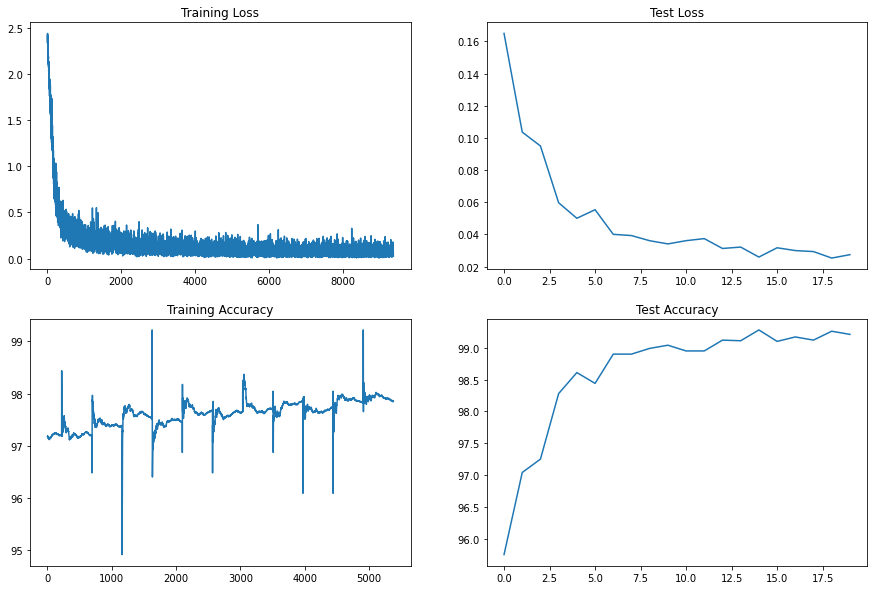

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Misclassification images

In [11]:
def wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])  
   
    return list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))

In [12]:
wrong_predictions = wrong_predictions(test_loader,model,device)
print(f'Total wrong predictions are {len(wrong_predictions)}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Total wrong predictions are 79


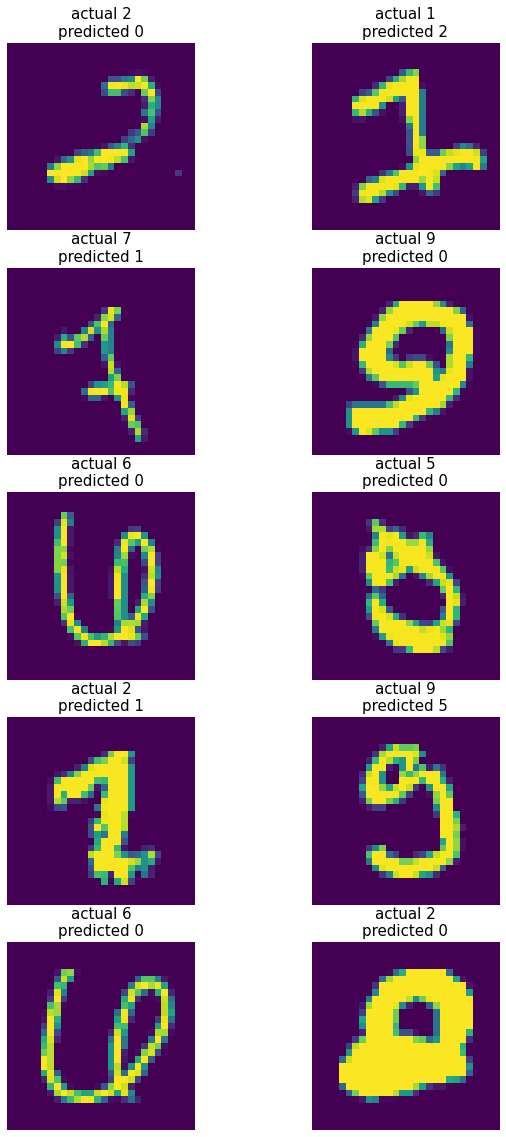

In [13]:
fig = plt.figure(figsize=(10,20))
for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
    img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
    ax = fig.add_subplot(5, 2, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())
plt.show()